# Methodological approach


### Models
- Baseline (TF-IDF + SVM with preprocessing): Train + Crossvalidation (default, 5-folds)
- Transformers: Validation is random sample of Train (10%). No cross-validation implemented yet, since not trivial

Both model classes use _class weights_ to address class imbalance problem and increase the effect on loss for minority classes. Uses the inverse of how many times a class is positive relative to negative, i.e. n_samples / (n_classes * np.bincount(y)

### Evaluation approach

    1) Train the models on the train set
    2) On each epoch, run evaluation with validation set and evaluation metric the Precision-Recall AuC
    3) Load at the end of training the model at the best performing epoch checkpoint.
    4) Do hyperparameter search and select the best model (of each model type)
    5) Predict the class labels for the __entire__ train set (so train + validation) and calculate the ROC/PR curves and AuC.
    6) Calculate the J-Stat (optimizing point in ROC space) and the F1 maximizing point in the Precision-Recall space
    7) Set class thresholds according to the F1 maximizing point
    8) Predict on the test set for model comparison (among model types)
    
### Scenarios

The following "scenarios" are defined:

- _optimistic_: Use only _positive_ labels for training, validation and test. This should give an "ceiling benchmark" of how good the _positive_ paragraphs can be separated/classified among themself.
- _efficient_realistic_: Use _Opportunities_ as _negative_ labels in training, use all negatives in test. 
- _realistic_: Use all negatives (opportunities, "weak" and "strong" from labelling process) for train and test.

| scenarios     | train           | test           |
| ------------- |:---------------:| --------------:|
| optimistic    | P: 279  N: 0    | P: 56   N:0    |
| efficient     | P: 279  N: 825  | P: 56 N: 28155 |
| realistic     | P: 279  N: 27533| P: 56 N: 28155 |

--> Note: Positives are counts of paragraphs with at least one positive label and negatives are those with all 0's.

### Tasks

- _binary_: Identification of CR relevant/irrelevant as baseline task. 
- _multi_label_cro_: Classification task of _Physical Risks_ and _Transition Risks_ with multi-labelling
- _multi_label_cro_sub_: Classification task of the 5 sub categories from _PR_ and _TR_

_multi_label_cro_sub_ is done as a second step after a _binary_ identification step. Train: All positives, Test: Overall Test dataset, where paragraphs that received a negative in the previous step are set to negative and included in the evaluation metrics to simulate a real word scenario, where the first step would act as a filter. Results are still pending here, since there seems to be an issue loading pretrained models https://github.com/huggingface/transformers/issues/8272.


# Results

Tables for each task below. As we know already, models perform well in the "naive" scenarios and bad once the negatives are considered. Performance improves once the full negative training data is provided. The relatively small and efficient distilbert-base-uncased performs best, beating the baseline but also roberta-large (in fact also other, bigger models. Needs certainly some investigation). Best PR AuC and F1-Score (at the threshold set according to the train results) for the test is at 48% for the binary task and at/below 40% for the 


# Questions

- Cross-validation with Transformers: What do we gain? More robust estimates of the validation metrics? Which model do we load at the end?
- Step 3 in Evaluation approach. For some models/scenarios, if more than 2-3 epochs are used, the eval loss starts increasing while the ROC-AuC/PR-AuC also increase, suggesting overfitting. Should we switch back to "loss" for best model selection?
- Step 4/5, selection of the thresholds: Is that o.k to run it on the entire train set? Alternative: Only validation set...

# Way forward (not in scope of the thesis)

- More data: Maybe we can invert the problem, e.g. consider the train/test set as test set, since there we have "negatives" (and as such a ground truth) and then start collecting training data (were we do not really have to have the ground truth)
- Revisit the paragraph approach: Split paragraphs in sentences
- Investigate labelled data after prediction, i.e. look at the most confusing examples etc to maybe find a pattern or label correction



# Dataset

In [3]:
%load_ext autoreload
%autoreload 2

import sys
import os

import pandas as pd

sys.path.append('..')
from data import constants
from data import cro_dataset
from data.utils import tables

ds_pos = cro_dataset.prepare_datasets(
    cro_category_level="cro_sub_type_combined", #cro_sub_type_combined
    should_filter_op=True, 
    train_neg_sampling_strategy=None, 
    test_neg_sampling_strategy=None, 
    as_huggingface_ds=True
)

ds_neg = cro_dataset.prepare_datasets(
    cro_category_level="cro_sub_type_combined", #cro_sub_type_combined
    should_filter_op=True, 
    train_neg_sampling_strategy="all", 
    test_neg_sampling_strategy="all", 
    as_huggingface_ds=True
)

ds_op = cro_dataset.prepare_datasets(
    cro_category_level="cro_sub_type_combined", #cro_sub_type_combined
    should_filter_op=False, 
    train_neg_sampling_strategy=None, 
    test_neg_sampling_strategy=None, 
    as_huggingface_ds=True
)

# Also read the negatives from the adjunct fix
ds_train_neg = pd.read_pickle("/Users/david/Nextcloud/Dokumente/Education/Uni Bern/Master Thesis/Analyzing Financial Climate Disclosures with NLP/Labelling/annual reports/Firm_AnnualReport_Labels_Training_Negative_incl_adjunct.pkl")
number_adjunct_fix = len(ds_train_neg.query("is_adjunct == True"))



DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 279
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 56
    })
})
DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 27811
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 28209
    })
})
DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 1103
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 77
    })
})


In [14]:
class_labels = ds_pos['train'].features['labels'].feature.names

train_df = pd.DataFrame(data=ds_pos['train']['labels'], columns=class_labels)
test_df = pd.DataFrame(data=ds_pos['test']['labels'], columns=class_labels)

df_labels = pd.DataFrame(data={"Training": train_df.sum(), "Test": test_df.sum() })
df_labels.rename(index=constants.map_to_field(), inplace=True)
df_labels.loc["Positive paragraphs"] =  [ ds_pos['train'].num_rows, ds_pos['test'].num_rows]
df_labels.loc['Negative paragraphs'] = [ ds_neg['train'].num_rows - ds_pos['train'].num_rows + number_adjunct_fix, ds_neg['test'].num_rows - ds_pos['test'].num_rows]
df_labels.loc['Opportunities'] = [ ds_op['train'].num_rows - ds_pos['train'].num_rows, ds_op['test'].num_rows - ds_pos['test'].num_rows ]
tables.export_to_latex(df_labels, filename="labels_dataset.tex")

'\\begin{tabular}{lrr}\n\\toprule\n{} &  Training &   Test \\\\\n\\midrule\nAcute               &       113 &     21 \\\\\nChronic             &        21 &      7 \\\\\nPolicy \\& Legal      &       109 &     20 \\\\\nTechnology \\& Market &        50 &     12 \\\\\nReputation          &        29 &      7 \\\\\nPositive paragraphs &       279 &     56 \\\\\nNegative paragraphs &     52349 &  28153 \\\\\nOpportunities       &       824 &     21 \\\\\n\\bottomrule\n\\end{tabular}\n'

# Results

In [30]:
import os
import re
import pandas as pd

RESULT_DIR = "/Users/david/Nextcloud/Dokumente/Education/Uni Bern/Master Thesis/Analyzing Financial Climate Disclosures with NLP/Methodology/results"

try:
  import google.colab
  is_running_in_colab = True
except:
  is_running_in_colab = False
  
if is_running_in_colab:
  # Load Google drive where the data and models are stored
  from google.colab import drive
  drive.mount('/content/drive')
  RESULT_DIR = "/content/drive/MyDrive/fin-disclosures-nlp/results/"

scenarios = ["optimistic", "efficient-realistic", "realistic"]
models = ["svm", "distilbert-base-uncased", "roberta-large"]
prefixes = ['test', 'train'] # 'eval' would also be there, however overlapping 'eval_roc_auc', 'eval_pr_auc',
report_columns = ['train_ROC AuC', 'train_PR AuC', 'test_ROC AuC', 'test_PR AuC', 'test_F1']

def sort_first_idx(idx):
    mapper = {name: order for order, name in enumerate(scenarios)}
    return idx.map(mapper)

def sort_second_idx(idx):
    mapper = {name: order for order, name in enumerate(models)}
    return idx.map(mapper)

def report_results(df):
    df[['scenario', 'model']] = df.id.str.split('_', 1, expand=True)
    # Set the row multi-index
    df = df.set_index(['scenario', 'model'])
    df = df.sort_index(key=sort_second_idx, level="model", sort_remaining=False).sort_index(key=sort_first_idx, level="scenario", sort_remaining=False)
    
    df = df[[r for r in report_columns if r in df.columns ]]
    
    # Set the column multi-index
    first_lvl = []
    second_lvl = []
    for c in df.columns:
        splits = c.split("_", 1)
        first = splits[0] if splits[0] in prefixes else ""
        second = splits[1] if splits[0] in prefixes else c
        first_lvl.append(first)
        second_lvl.append(second)
    df.columns = [first_lvl, second_lvl]
    
    df = df.round(3)
    return df

binary_df = pd.read_csv(os.path.join(RESULT_DIR, "cro_sub_type_combined_binary_results.csv"))
multilabel_df = pd.read_csv(os.path.join(RESULT_DIR, "cro_multi-label_results.csv"))

In [23]:
print("Binary Task: ")
binary_report = report_results(binary_df)
binary_report

Binary Task: 


train           test         \
                                            ROC AuC PR AuC ROC AuC PR AuC   
scenario            model                                                   
optimistic          svm                       1.000  1.000   0.935  0.998   
                    distilbert-base-uncased   0.492  0.997   0.685  0.985   
                    roberta-large             0.760  0.999   0.157  0.934   
efficient-realistic svm                       0.999  0.994   0.868  0.071   
                    distilbert-base-uncased   0.993  0.987   0.950  0.069   
                    roberta-large             0.623  0.470   0.696  0.007   
realistic           svm                       0.999  0.977   0.984  0.374   
                    distilbert-base-uncased   0.998  0.960   0.989  0.527   
                    roberta-large             0.808  0.072   0.815  0.025   

                                                    
                                                F1  
scenario            model                           
optimistic          svm                      0.920  
                    distilbert-base-uncased  0.982  
                    roberta-large            0.982  
efficient-realistic svm                      0.021  
                    distilbert-base-uncased  0.021  
                    roberta-large            0.004  
realistic           svm                      0.278  
                    distilbert-base-uncased  0.339  
                    roberta-large            0.000

In [31]:
print("Multi-Label Task: ")
multilabel_report = report_results(multilabel_df)
multilabel_report

Multi-Label Task: 


train           test         \
                                            ROC AuC PR AuC ROC AuC PR AuC   
scenario            model                                                   
optimistic          svm                       0.995  0.995   0.944  0.959   
                    distilbert-base-uncased   0.984  0.986   0.943  0.958   
                    roberta-large             0.982  0.985   0.959  0.968   
efficient-realistic svm                       0.999  0.989   0.911  0.138   
                    distilbert-base-uncased   0.986  0.950   0.947  0.215   
                    roberta-large             0.601  0.229   0.703  0.011   
realistic           svm                       1.000  0.972   0.982  0.331   
                    distilbert-base-uncased   0.988  0.827   0.990  0.390   
                    roberta-large             0.571  0.006   0.549  0.001   

                                                    
                                                F1  
scenario            model                           
optimistic          svm                      0.741  
                    distilbert-base-uncased  0.865  
                    roberta-large            0.889  
efficient-realistic svm                      0.125  
                    distilbert-base-uncased  0.033  
                    roberta-large            0.006  
realistic           svm                      0.238  
                    distilbert-base-uncased  0.364  
                    roberta-large            0.000

In [29]:
results_df = binary_report.merge(multilabel_report, left_index=True, right_index=True, suffixes=('_binary', '_multilabel'))
tables.export_to_latex(results_df, filename="methodology_results.tex")
results_df

train_binary        test_binary  \
                                                 ROC AuC PR AuC     ROC AuC   
scenario            model                                                     
optimistic          svm                            1.000  1.000       0.935   
                    distilbert-base-uncased        0.492  0.997       0.685   
                    roberta-large                  0.760  0.999       0.157   
efficient-realistic svm                            0.999  0.994       0.868   
                    distilbert-base-uncased        0.993  0.987       0.950   
realistic           svm                            0.999  0.977       0.984   
                    distilbert-base-uncased        0.998  0.960       0.989   
                    roberta-large                  0.808  0.072       0.815   

                                                          train_multilabel  \
                                            PR AuC     F1          ROC AuC   
scenario            model                                                    
optimistic          svm                      0.998  0.920            0.992   
                    distilbert-base-uncased  0.985  0.982            0.905   
                    roberta-large            0.934  0.982            0.924   
efficient-realistic svm                      0.071  0.021            0.996   
                    distilbert-base-uncased  0.069  0.021            0.942   
realistic           svm                      0.374  0.278            0.998   
                    distilbert-base-uncased  0.527  0.339            0.460   
                    roberta-large            0.025  0.000            0.559   

                                                   test_multilabel         \
                                            PR AuC         ROC AuC PR AuC   
scenario            model                                                   
optimistic          svm                      0.917           0.913  0.777   
                    distilbert-base-uncased  0.764           0.792  0.638   
                    roberta-large            0.785           0.771  0.578   
efficient-realistic svm                      0.861           0.932  0.071   
                    distilbert-base-uncased  0.573           0.948  0.057   
realistic           svm                      0.832           0.960  0.230   
                    distilbert-base-uncased  0.326           0.442  0.107   
                    roberta-large            0.043           0.570  0.010   

                                                    
                                                F1  
scenario            model                           
optimistic          svm                      0.442  
                    distilbert-base-uncased  0.497  
                    roberta-large            0.445  
efficient-realistic svm                      0.104  
                    distilbert-base-uncased  0.046  
realistic           svm                      0.196  
                    distilbert-base-uncased  0.159  
                    roberta-large            0.026

Note: These ROC and P-R curves are the plots after training, on the entire TRAIN set and are used to find the optimal threshold values (dot).


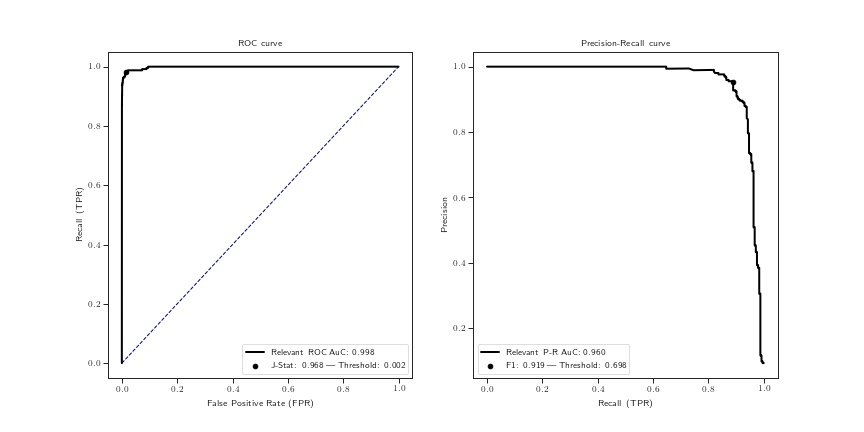

In [6]:
import os
from IPython.display import Image 

print("Note: These ROC and P-R curves are the plots after training, on the entire TRAIN set and are used to find the optimal threshold values (dot).")
path = "/Users/david/Nextcloud/Dokumente/Education/Uni Bern/Master Thesis/Analyzing Financial Climate Disclosures with NLP/Methodology/results/figures/"
Image(filename = os.path.join(path, "cro_sub_type_combined_binary_realistic_distilbert-base-uncased_train_threshold.pdf.jpg"))

Confusion matrix on the test set...


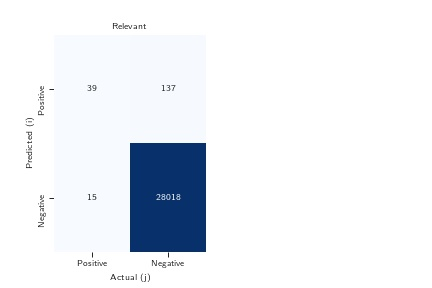

In [7]:
from IPython.display import Image 

print("Confusion matrix on the test set...")
path = "/Users/david/Nextcloud/Dokumente/Education/Uni Bern/Master Thesis/Analyzing Financial Climate Disclosures with NLP/Methodology/results/figures/"
Image(filename = os.path.join(path, "cro_sub_type_combined_binary_realistic_distilbert-base-uncased_test_evaluation.pdf.jpg"))

# 2 Stage: use the "test_predictions.pkl" in the labels folder, the thresholds from the results folders (or here: 

1Stage: [0.69809985]
2Stage: [0.19047296, 0.25015372, 0.36645192, 0.27023202, 0.2140553])


    1. Plot the confusion matrix of the first stage
    2. Plot the decision threshold of the second stage
    3. Plot the confusion matrix of the combined second stage of all 5 categories and converted to main categories

In [32]:
import pandas as pd
two_stage = pd.read_pickle("/Users/david/Nextcloud/Dokumente/Education/Uni Bern/Master Thesis/Analyzing Financial Climate Disclosures with NLP/Methodology/data/labels/test_predictions.pkl")

In [36]:
two_stage.binary_pred_labels

0        0
1        0
2        0
3        0
4        0
        ..
28204    0
28205    0
28206    0
28207    0
28208    0
Name: binary_pred_labels, Length: 28209, dtype: int64

In [41]:
two_stage.multilabel_pred_labels

0        [0, 0, 0, 0, 0]
1        [0, 0, 0, 0, 0]
2        [0, 0, 0, 0, 0]
3        [0, 0, 0, 0, 0]
4        [0, 0, 0, 0, 0]
              ...       
28204    [0, 0, 0, 0, 0]
28205    [0, 0, 0, 0, 0]
28206    [0, 0, 0, 0, 0]
28207    [0, 0, 0, 0, 0]
28208    [0, 0, 0, 0, 0]
Name: multilabel_pred_labels, Length: 28209, dtype: object